In [1]:
from pathlib import Path

import torch

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader

In [2]:
checkpoints = [Path("../runs/RESULTS/STANDARD")]
checkpoint_dir = checkpoints[0]

config_path = checkpoint_dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)

config.network_loader.decoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"
config.network_loader.encoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"

device = torch.device("cuda")

encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [3]:
from dynamic_fusion.utils.dataset import CocoTestDataset
from dynamic_fusion.utils.dataset import collate_test_items
from dynamic_fusion.utils.evaluation import get_metrics


dataset_path = Path('..', 'data', 'interim', 'coco', 'test', '2subbins')

dataset = CocoTestDataset(dataset_path, (1,1), threshold=1.35, subbins=2)
get_metrics(dataset, encoder, decoder, config.shared, device, taus_to_evaluate=1, Ts_to_evaluate=150, reduce=False)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Loading pretrained model LPIPS from /home/davton/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth


  0%|          | 0/11 [00:00<?, ?it/s]/home/davton/dev/dynamic-fusion/dynamic_fusion/utils/evaluation.py:413: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lpips_val = lpips(torch.tensor(patched_recon[i : i + lpips_batch, 0:1]).cuda(), torch.tensor(patched_gt[i : i + lpips_batch]).cuda())
100%|██████████| 11/11 [01:57<00:00, 10.66s/it]


{'PSNR': [20.303936933571013,
  13.642141012913244,
  18.3021641559756,
  16.669108884492754,
  18.304290467039124,
  18.398079339303038,
  19.09481681106911,
  20.404293097879627,
  19.533359275389422,
  16.67756561450118,
  16.86115375736673],
 'SSIM': [0.7207056130576048,
  0.41228398009662276,
  0.5347767785214762,
  0.5952109160157367,
  0.7324553071483269,
  0.7773781383601833,
  0.7005504920670994,
  0.6933984442935839,
  0.4734638071652789,
  0.6344679759114066,
  0.47241396640538447],
 'MSE': [0.009479186497628689,
  0.043524984270334244,
  0.015685437247157097,
  0.022453628480434418,
  0.015094738453626633,
  0.01585203781723976,
  0.013163847848773003,
  0.010807126760482788,
  0.011313148774206638,
  0.021970635280013084,
  0.020663637667894363],
 'LPIPS': [0.31392974456151335,
  0.3189148793617884,
  0.27604891359806055,
  0.22798111438751226,
  0.21926815956830978,
  0.1901978388428688,
  0.272127873202165,
  0.27102218667666117,
  0.3046570658683776,
  0.259229153394699

In [8]:


from dynamic_fusion.utils.array import to_numpy
from dynamic_fusion.utils.evaluation import get_reconstructions_and_gt
from dynamic_fusion.utils.network import network_test_data_to_device
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap

i_sample = 6
sample = dataset[i_sample]
batch = collate_test_items([sample])
scale = dataset.scales[i_sample]
recon, gt, _, _ = get_reconstructions_and_gt(
    batch,
    encoder,
    decoder,
    config.shared,
    device,
    scale=scale,
    Ts_to_evaluate=150,
    taus_to_evaluate=1,
    gt_taus_to_evaluate=None,
    gt_scale=None,
)
eps = sample[4]
colored_event_polarity_sums = img_to_colormap(to_numpy(eps.sum(dim=1)), create_red_blue_cmap(501))


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


(-0.5, 101.5, 101.5, -0.5)

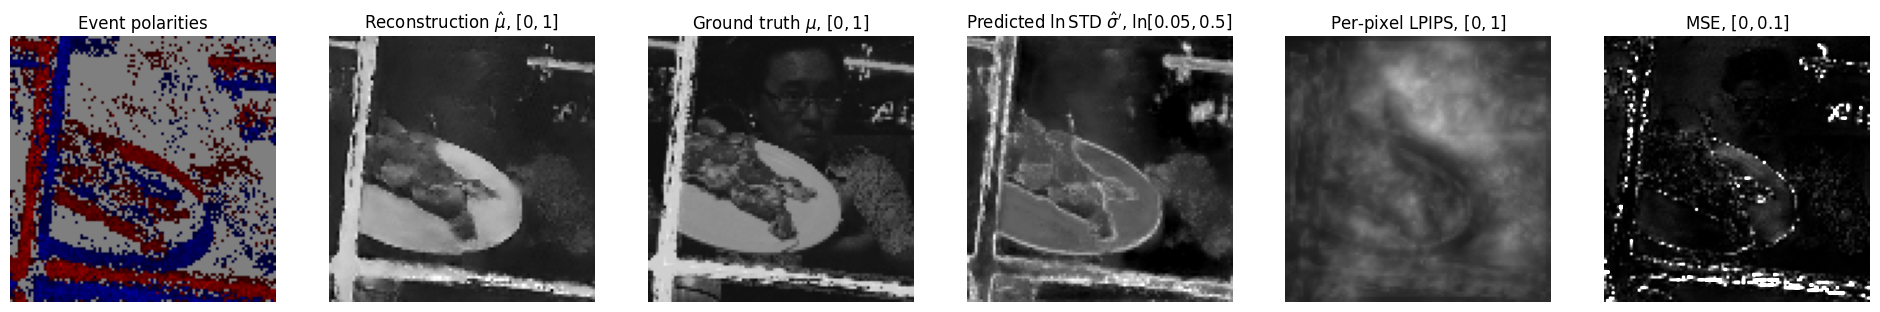

In [9]:
from matplotlib import pyplot as plt
import numpy as np

from dynamic_fusion.utils.loss import LPIPS
I = 100
fig, axs = plt.subplots(1,6, figsize=(24, 8))

axs[0].imshow(colored_event_polarity_sums[I])
axs[0].set_title('Event polarities')
axs[0].axis('off')

axs[1].imshow(recon[I,0], cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Reconstruction $\hat{\mu}$, $[0,1]$')
axs[1].axis('off')


axs[2].imshow(gt[I], cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Ground truth $\mu$, $[0,1]$')
axs[2].axis('off')


axs[3].imshow(recon[I,1], cmap='gray', vmin=np.log(0.05), vmax=np.log(0.5))
axs[3].set_title('Predicted $\ln$STD $\hat{\sigma}\'$, $\ln[0.05, 0.5]$')
axs[3].axis('off')

lpips = LPIPS(spatial=True)
lpips_val = lpips(torch.tensor(recon[I:I+1, 0:1]), torch.tensor(gt[I:I+1, None]) )

axs[4].imshow(to_numpy(lpips_val[0,0]), cmap='gray', vmin=0, vmax=1)
axs[4].set_title('Per-pixel LPIPS, $[0,1]$')
axs[4].axis('off')

axs[5].imshow((recon[I,0] - gt[I]) ** 2, cmap='gray', vmin=0, vmax=0.1)
axs[5].set_title('MSE, $[0, 0.1]$')
axs[5].axis('off')



In [7]:
recon.shape

(150, 2, 106, 106)

In [7]:
ll = (-np.log(2*np.pi) / 2 - recon[I, 1] - 1/2 * np.square((gt[I] - recon[I,0])/np.exp(recon[I,1])))

In [7]:
ll = (-np.log(2*np.pi) / 2 - recon[:, 1] - 1/2 * np.square((gt[:] - recon[:,0])/np.exp(recon[:,1])))
ll.mean()

0.85445803

In [18]:
((-np.log(2 * np.pi) / 2 - torch.tensor(recon[:, 1]) - 1 / 2 * torch.square((torch.tensor(gt) - torch.tensor(recon[:, 0])) / torch.exp(torch.tensor(recon[:, 1])))).mean().item())


0.6802507042884827

In [159]:
(recon[I,0] - gt[I]) ** 2

array([[1.06051955e-02, 1.31389759e-02, 8.61648284e-03, ...,
        3.27892508e-03, 4.19161608e-03, 2.70399614e-03],
       [1.05874725e-02, 1.02533251e-02, 9.44955368e-03, ...,
        2.79214303e-03, 3.17091332e-03, 1.77039602e-03],
       [1.43074282e-02, 1.15735894e-02, 1.39552634e-02, ...,
        2.84664769e-04, 1.52981272e-06, 8.51556601e-04],
       ...,
       [7.37236161e-03, 7.08838634e-04, 3.20000079e-04, ...,
        1.32043846e-02, 2.90174577e-02, 6.45439252e-02],
       [5.49196079e-03, 1.38683303e-03, 9.39917052e-04, ...,
        2.72613892e-04, 2.22105086e-02, 2.94930600e-02],
       [9.08393413e-03, 3.37418664e-04, 1.90966215e-03, ...,
        3.32144613e-04, 1.62123039e-01, 1.27808917e-02]], dtype=float32)

In [195]:
torch.zeros((3,3,3)).size()

torch.Size([3, 3, 3])

0.7907235946313946


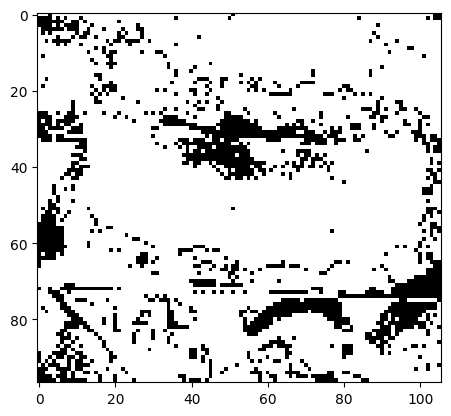

In [119]:
z = 1
interval = [recon[:,0] - z*np.exp(recon[:,1]), recon[:,0] + z*np.exp(recon[:,1])]
print(np.logical_and(gt > interval[0], gt < interval[1]).sum() / gt.size)
I = 99
interval = [recon[I,0] - z*np.exp(recon[I,1]), recon[I,0] + z*np.exp(recon[I,1])]
plt.imshow(np.logical_and(gt[I] > interval[0], gt[I] < interval[1]), cmap='gray')

In [137]:
(recon[I, 0] - gt[I])

array([[ 0.10298153,  0.11462537,  0.09282501, ...,  0.0572619 ,
         0.06474269,  0.05199996],
       [ 0.10289545,  0.1012587 ,  0.09720881, ...,  0.05284073,
         0.05631086,  0.04207607],
       [ 0.11961366,  0.10758062,  0.1181324 , ...,  0.01687201,
         0.00123686,  0.02918144],
       ...,
       [-0.08586246, -0.02662402, -0.01788855, ...,  0.11491033,
         0.17034511, -0.25405496],
       [-0.07410777, -0.03724021, -0.03065807, ...,  0.01651102,
        -0.1490319 ,  0.17173544],
       [-0.09530967, -0.01836896, -0.04369968, ..., -0.01822484,
        -0.40264505, -0.11305261]], dtype=float32)

In [139]:
np.corrcoef((np.square(recon[I, 0] - gt[I])).flatten(), recon[I:I+1, 1].flatten())[0, 1]


0.40731920740291333